### Classifier with w2v vectors

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics  import f1_score,accuracy_score
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import cross_validate
from sklearn import svm
import keras
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [3]:
train_set = pd.read_csv("dataset_train_pp.csv")
test_set = pd.read_csv("dataset_test_pp.csv")

In [4]:
print(len(train_set))
print(len(test_set))

50000
5000


In [5]:
train_x=train_set["Description"]
test_x=test_set["Description"]

train_y=train_set["Class Index"]
test_y=test_set["Class Index"]

In [7]:
%%time
test_x_vectors = np.load("w2v_test_x_google.npy")

CPU times: user 3.63 ms, sys: 8.1 ms, total: 11.7 ms
Wall time: 375 ms


In [8]:
%%time
train_x_vectors = np.load("w2v_train_x_google.npy")

CPU times: user 8.89 ms, sys: 70.2 ms, total: 79.1 ms
Wall time: 1.42 s


In [9]:
# plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='confusion_matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], 
                horizontalalignment='center', 
                color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Naive Bays

In [9]:
naive_bays = MultinomialNB()

In [10]:
%%time
naive_bays.fit(train_x_vectors, train_y)

CPU times: user 183 ms, sys: 113 ms, total: 296 ms
Wall time: 192 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [11]:
nb_pred_x = naive_bays.predict(test_x_vectors)

In [12]:
accuracy_score(test_y,nb_pred_x)

0.7886

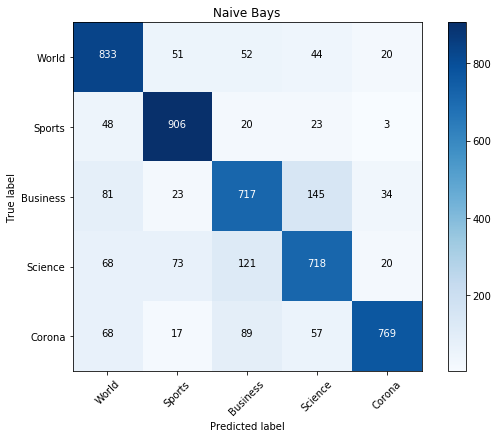

In [13]:
nb_cm = confusion_matrix(test_y, nb_pred_x)
cmPlotLabels = ['World', 'Sports', 'Business', 'Science', 'Corona']
plot_confusion_matrix(nb_cm, cmPlotLabels, title='Naive Bays')

### SVM

In [16]:
svm_model = svm.SVC(kernel='poly', degree=2, gamma='scale')

In [18]:
%%time
svm_model.fit(train_x_vectors, train_y)
# svm_model.fit(test_x_vectors, test_y) for speed test

CPU times: user 13min 20s, sys: 4.15 s, total: 13min 24s
Wall time: 13min 25s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [19]:
svm_pred_x = svm_model.predict(test_x_vectors)

In [20]:
accuracy_score(test_y,svm_pred_x)

0.88

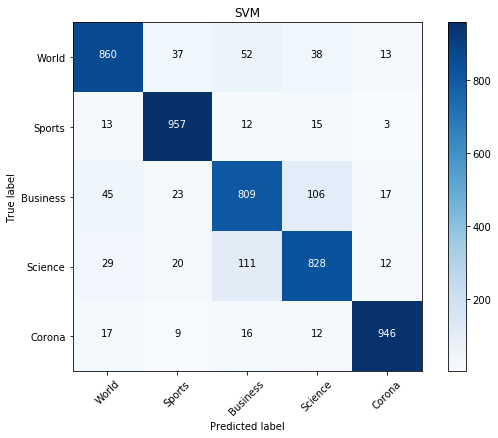

In [22]:
svm_cm = confusion_matrix(test_y, svm_pred_x)
plot_confusion_matrix(svm_cm, cmPlotLabels, title='SVM')

https://stackoverflow.com/questions/10592605/save-classifier-to-disk-in-scikit-learn

### NN

#### Prepare labels for keras

In [10]:
enc = OneHotEncoder(handle_unknown='ignore')

In [11]:
test_y_array = test_y.to_numpy().reshape(-1,1)
train_y_array = train_y.to_numpy().reshape(-1,1)

In [12]:
enc.fit(test_y_array)
test_y_1hot = enc.transform(test_y_array).toarray()

In [13]:
enc.fit(train_y_array)
train_y_1hot = enc.transform(train_y_array).toarray()

#### keras model

In [19]:
nn_model = None
nn_model = keras.models.Sequential()
nn_model.add(keras.layers.Dense(32, input_dim=300, activation='relu'))
nn_model.add(keras.layers.Dense(16, activation='relu'))
nn_model.add(keras.layers.Dense(16, activation='relu'))
nn_model.add(keras.layers.Dense(5, activation='softmax'))

In [20]:
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                9632      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 85        
Total params: 10,517
Trainable params: 10,517
Non-trainable params: 0
_________________________________________________________________


In [21]:
nn_model.compile(keras.optimizers.Adam(lr=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
%%time
nn_model.fit(train_x_vectors, train_y_1hot, epochs=30, batch_size=10)

Epoch 1/30
50000/50000 [==============================] - 16s 311us/step - loss: 0.6556 - acc: 0.7679
Epoch 2/30
50000/50000 [==============================] - 15s 295us/step - loss: 0.4661 - acc: 0.8408
Epoch 3/30
50000/50000 [==============================] - 15s 299us/step - loss: 0.4445 - acc: 0.8469
Epoch 4/30
50000/50000 [==============================] - 15s 299us/step - loss: 0.4353 - acc: 0.8515
Epoch 5/30
50000/50000 [==============================] - 15s 298us/step - loss: 0.4288 - acc: 0.8534
Epoch 6/30
50000/50000 [==============================] - 15s 300us/step - loss: 0.4237 - acc: 0.8542
Epoch 7/30
50000/50000 [==============================] - 15s 301us/step - loss: 0.4171 - acc: 0.8561
Epoch 8/30
50000/50000 [==============================] - 15s 303us/step - loss: 0.4106 - acc: 0.8586
Epoch 9/30
50000/50000 [==============================] - 15s 304us/step - loss: 0.4052 - acc: 0.8596
Epoch 10/30
50000/50000 [==============================] - 15s 304us/step - loss: 

In [24]:
nn_model.evaluate(test_x_vectors, test_y_1hot, batch_size=10)

5000/5000 [==============================] - 1s 154us/step


[0.40315946845834244, 0.8605999954938889]

In [25]:
predictions = nn_model.predict(test_x_vectors)

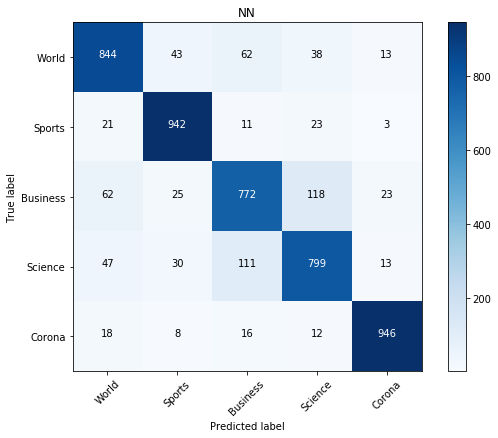

In [27]:
nn_cm = confusion_matrix(test_y, predictions.argmax(axis=1)+1)
cmPlotLabels = ['World', 'Sports', 'Business', 'Science', 'Corona']
plot_confusion_matrix(nn_cm, cmPlotLabels, title='NN')

In [23]:
nn_model.save("nn_w2v_google")